Import Libraries

In [43]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
from flax.experimental import nnx
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

Unpickling the data

In [44]:
# Due to errors I was experiencing this seems to be the quickest fix I could find to allow me to unpickle the data
import sys
import types
import pickle

fake_module = types.ModuleType("DataSetup")

class DataStore:
    def __init__(self):
        pass

fake_module.DataStore = DataStore

sys.modules["DataSetup"] = fake_module

data_file_1 = r"C:\Users\samue\Downloads\Simulation.pickle"
data_file_2 = r"C:\Users\samue\Downloads\Simulation 2.pickle"

with open(data_file_1,"rb") as f:
    data_unpickled_1 = pickle.load(f)

with open(data_file_2,"rb") as f:
    data_unpickled_2 = pickle.load(f)

_,data_object_1 = data_unpickled_1
_,data_object_2 = data_unpickled_2

input_dataset_1 = jnp.array(data_object_1.Indata)
#data_index_1 = data_object_1.i
e_dataset_1 = jnp.array(data_object_1.SE)
e_prime_dataset_1 = jnp.array(data_object_1.Jac)

input_dataset_2 = jnp.array(data_object_2.Indata)
#data_index_2 = data_object_2.i
e_dataset_2 = jnp.array(data_object_2.SE)
e_prime_dataset_2 = jnp.array(data_object_2.Jac)

print(input_dataset_2.shape)
print(input_dataset_1.shape)
print(e_dataset_1.shape)
print(e_prime_dataset_1.shape)

input_dataset = jax.numpy.concatenate([input_dataset_1,input_dataset_2],axis=0)
target_e_dataset = jax.numpy.concatenate([e_dataset_1, e_dataset_2],axis=0)
target_e_dataset = jax.numpy.expand_dims(target_e_dataset,axis=1)
target_e_prime_dataset = jax.numpy.concatenate([e_prime_dataset_1,e_prime_dataset_2],axis=0)
print(input_dataset.shape)
print(target_e_dataset.shape)
print(target_e_prime_dataset.shape)

(10000, 152, 3)
(10000, 152, 3)
(10000,)
(10000, 152, 3)
(20000, 152, 3)
(20000, 1)
(20000, 152, 3)


Redimensionalise

In [45]:
def Redimensionalise(self):
    self.Disp = jnp.zeros((self.Dims,self.Dims,self.Dims,3))
    m = 0
    for i in range(self.Dims):
        for j in range(self.Dims):
            for k in range(self.Dims):
                if self.xInMesh[0][i,j,k] == 0 or self.xInMesh[0][i,j,k] == 1 or self.xInMesh[1][i,j,k] == 0 or self.xInMesh[1][i,j,k] == 1 or self.xInMesh[2][i,j,k] == 0 or self.xInMesh[2][i,j,k] == 1:
                    self.Disp[i,j,k,:] = self.RandDisp[self.Index,m,:]
                    m = m +1
    return self.Disp
    

RNG key

In [46]:
seed = 42 # This can be changed but is here to make the results easy to reproduce

base_key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(base_key)

Hyper Params

In [47]:
Epochs = 10
alpha = 1.0
gamma = 1.0
lambda_ = 1.0
Learn_Rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
Batch_size = 10

Dataset

In [48]:
batch_num = input_dataset.shape[0] // Batch_size

# input_dataset target_e_dataset target_e_prime_dataset 

input_dataset = input_dataset.reshape((20000,456))
target_e_dataset = target_e_dataset.reshape((20000,))
target_e_prime_dataset = target_e_prime_dataset.reshape((20000,456))

Dataset = {
    'displacements':input_dataset,
    'target_e':target_e_dataset,
    'target_e_prime':target_e_prime_dataset
}


Node Classes and Acivations

In [49]:
class Linear(nnx.Module):
    """Linear node for neural network"""

    def __init__(self,din: int,dout: int,*,rngs: nnx.Rngs):
        key = rngs.params()
        self.W = nnx.Param(jax.random.uniform(key=key, shape=(din,dout)))
        self.b = nnx.Param(jnp.zeros(shape=(dout,)))
        self.din, self.dout = din, dout

    def __call__(self,x: jax.Array):
        return(x @ self.W + self.b)
    
def SiLU(x: jax.Array):
    """Sigmoid Weighted Linear Unit activation function"""
    return x * jax.nn.sigmoid(x)

Model Architecture

In [50]:
class energy_prediction(nnx.Module):
    """Model architecture"""

    def __init__(self,dim_in: int, dim_hidden1_in: int, dim_hidden2_in: int,dim_hidden3_in, dim_out: int,*,rngs: nnx.Rngs):
        self.layer1 = Linear(din=dim_in,dout=dim_hidden1_in,rngs=rngs)
        self.layer2 = Linear(din=dim_hidden1_in,dout=dim_hidden2_in,rngs=rngs)
        self.layer3 = Linear(din=dim_hidden2_in,dout=dim_hidden3_in,rngs=rngs)
        self.layer4 = Linear(din=dim_hidden3_in,dout=dim_out,rngs=rngs)
        self.silu = SiLU
        
    def __call__(self,x_in):
        # pass to calculate e
        def forwardPass(x):
            x = self.layer1(x)
            x = self.silu(x)
            x = self.layer2(x)
            x = self.silu(x)
            x = self.layer3(x)
            x = self.silu(x)
            x = self.layer4(x)
            return x.squeeze(-1)
        
        e = forwardPass(x_in)
        dedx = jax.vmap(jax.grad(forwardPass,argnums=(0)))
        e_prime = dedx(x_in)

        return e, e_prime


Define optimiser and loss

In [51]:
optimiser = optax.adam(learning_rate=Learn_Rate, b1=beta_1, b2=beta_2)

def loss_fn(x: jax.Array, target_e, target_e_prime,*, model,alpha,gamma,lam): 
    """
    Calculates the loss of a model, works to minimise the mean square error of both 
    the strain energy prediction and the strain energy derivative prediction,
    whilst forcing the function through zero.
    """

    prediction_e, prediction_e_prime = model(x)
    loss_e = jnp.mean((prediction_e - target_e)**2)
    loss_e_prime = jnp.mean((prediction_e_prime - target_e_prime)**2)

    target_zero = 0
    x_zero = jnp.zeros(x[0].shape)
    x_zero = jnp.expand_dims(x_zero, axis=0)
    prediction_zero, _ = model(x_zero)
    loss_zero = jnp.mean((prediction_zero - target_zero)**2)

    return (alpha * loss_e + gamma * loss_e_prime + lam * loss_zero)

Train State Bundle

In [52]:
class TrainState:
    def __init__(self,*,model_def,params,optimiser,opt_state,alpha,gamma,lambda_):
        self.model_def = model_def
        self.params = params
        self.optimiser = optimiser
        self.opt_state = opt_state
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_ = lambda_

    def replace(self,*,model_def,params,optimiser,opt_state,alpha,gamma,lambda_):
        self.model_def = model_def
        self.params = params
        self.optimiser = optimiser
        self.opt_state = opt_state
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_ = lambda_
        return self

Train Step

In [53]:
@nnx.jit(static_argnames=['params','optimiser','loss_fn'])
def training_step(Model_def,params,optimiser,opt_state,alpha,gamma,lambda_,batch,loss_fn):
    disp_in = batch['displacements']
    e_target = batch['target_e']
    e_prime_target = batch['target_e_prime']

    def wrapped_loss_fn(params):
        Model = nnx.merge(Model_def,params)
        loss = loss_fn(
            disp_in,
            e_target,
            e_prime_target,
            model=Model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )
        return loss

    loss = wrapped_loss_fn(params)
    grads = nnx.grad(wrapped_loss_fn)(params)
    updates, new_opt_state = optimiser.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss

Batch Creator and test set creator

In [54]:
def split_and_batch_dataset(dataset, batch_size, test_split=0.2, shuffle=True):
    """
    Splits the dataset into training and test sets, then yields batches for each.
    Returns: (train_batches, test_batches)
    """
    N = dataset['displacements'].shape[0]
    indices = jnp.arange(N)
    if shuffle:
        indices = jax.random.permutation(jax.random.PRNGKey(0), indices)
    split_idx = int(N * (1 - test_split))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    def batch_indices(idx):
        for start in range(0, len(idx), batch_size):
            end = start + batch_size
            batch_idx = idx[start:end]
            yield {key: value[batch_idx] for key, value in dataset.items()}

    train_batches = list(batch_indices(train_idx))
    test_batches = list(batch_indices(test_idx))
    return train_batches, test_batches

Create test and train batches

In [55]:
train_batches, test_batches = split_and_batch_dataset(
    Dataset, 
    Batch_size, 
    test_split=0.2, 
    shuffle=True
)

Training Loop

In [56]:
# Instantiate energy prediction NN
Model = energy_prediction(
    dim_in=input_dataset.shape[1], 
    dim_hidden1_in=2024,
    dim_hidden2_in=1012,
    dim_hidden3_in=212, 
    dim_out=1,
    rngs=rngs
)

params, Model_def = nnx.split(Model,nnx.Param)
opt_state = optimiser.init(params)
train_state = TrainState(
    model_def=Model_def,
    params=params,
    optimiser=optimiser,
    opt_state=opt_state,
    alpha=alpha,
    gamma=gamma,
    lambda_=lambda_,
    )

loss_record = []

for epoch in range(Epochs):
    running_loss = 0.0
    batch_count = 0

    for batch in tqdm(train_batches,desc=f"Epoch {epoch}/{Epochs}", leave=False):
        new_params, new_opt_state, loss_batch = training_step(
            Model_def=train_state.model_def,
            opt_state=train_state.opt_state,
            params=train_state.params,
            optimiser=train_state.optimiser,
            alpha=train_state.alpha,
            gamma=train_state.gamma,
            lambda_=train_state.lambda_,
            batch=batch,
            loss_fn=loss_fn
        )

        train_state = train_state.replace(
            model_def=train_state.model_def,
            opt_state=new_opt_state,
            params=new_params,
            optimiser=train_state.optimiser,
            alpha=train_state.alpha,
            gamma=train_state.gamma,
            lambda_=train_state.lambda_
        )

        running_loss += loss_batch
        batch_count += 1
    
    avg_loss = avg_loss = running_loss / batch_count if batch_count > 0 else 0.0
    loss_record.append(avg_loss)

AttributeError: No attribute 'num_leaves' in State

Final model storage

In [ ]:
class ModelData:
    def __init__(self,*,model_def,params,trained):
        self.model_def = model_def
        self.params = params
        self.trained = trained

    def is_trained(self):
        if self.trained:
            return True
        else:
            return False
        
    def evaluate(self):
        pass

Create Final model instance

In [ ]:
model_def_trained = train_state.model_def
params_trained = train_state.params

model_data = ModelData(
    model_def=model_def_trained,
    params=params_trained,
    trained=True
)

Plots

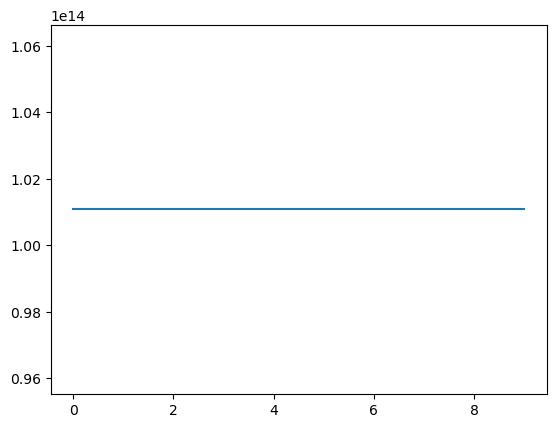

In [ ]:
plt.plot(loss_record)

Eval State

In [ ]:
test_model = train_state.model

class Eval_state:
    def __init__(self,model,params,alpha,gamma,lambda_):
        self.model = model
        self.params = params
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_ = lambda_

evaluation_state = Eval_state(
    model=test_model,
    params=1,
    alpha=alpha,
    gamma=gamma,
    lambda_=lambda_
)

AttributeError: module 'flax.nnx' has no attribute 'get_parameters'

Model Testing

In [ ]:
def avg_abs_error(pred,target):
    n1 = pred.shape[0]
    n2 = target.shape[0]

    if n1 != n2:
        raise("Error: inputs must have matching shape")
    
    return (jnp.sum(jnp.abs(pred - target)) / n1)

def test_model(evaluation_state,Batch_size,*,loss_fn):
    test_model = evaluation_state.model
    alpha = evaluation_state.alpha
    gamma = evaluation_state.gamma
    lambda_ = evaluation_state.lambda_
    
    loss_test = 0.0

    for batch in test_batches:
        displacements_test = batch['displacements']
        e_target_test = batch['target_e']
        e_prime_target_test = batch['target_e_prime']

        e_pred_test, e_prime_pred_test = test_model(displacements_test)

        batch_loss_test = loss_fn(
            displacements_test,
            e_target_test,
            e_prime_target_test,
            test_model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )

        loss_test += batch_loss_test

        avg_e_abs_error = avg_abs_error(e_pred_test,e_target_test)
        avg_e_prime_abs_error = avg_abs_error(e_prime_pred_test,e_prime_target_test)

    avg_loss_test = loss_test / Batch_size
    zero_val_e,zero_val_e_prime = test_model(jnp.zeros())
    test_e_zero_error = avg_abs_error(zero_val_e, jnp.zeros_like(zero_val_e))
    test_e_prime_zero_error = avg_abs_error(zero_val_e_prime, jnp.zeros_like(zero_val_e_prime))

    return avg_loss_test, avg_e_abs_error, avg_e_prime_abs_error, test_e_zero_error, test_e_prime_zero_error

